# Question 3

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from PIL import Image
import os

import numpy as np
import matplotlib.pyplot as plt

batch_size = 64


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class SketchPhotoDataset(Dataset):
    def __init__(self, img_dir, sketch_dir, transform=None):
        self.img_dir = img_dir
        self.sketch_dir = sketch_dir
        self.transform = transform
        self.img_list = os.listdir(img_dir)
        self.sketch_list = os.listdir(sketch_dir)

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        string_idx = str(self.img_list[idx].split('.')[0])
        img_path = os.path.join(self.img_dir, string_idx + '.jpg')
        sketch_path = os.path.join(self.sketch_dir, string_idx + '.jpg')
        
        img = Image.open(img_path).convert('RGB')
        sketch = Image.open(sketch_path).convert('L')  # Convert sketch to grayscale
        
        if self.transform:
            img = self.transform(img)
            sketch = self.transform(sketch)
        
        return img, sketch

2065
339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.947479..0.7709559].


torch.Size([3, 256, 256])


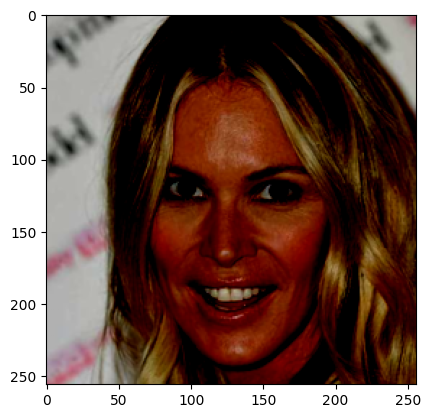

torch.Size([1, 256, 256])


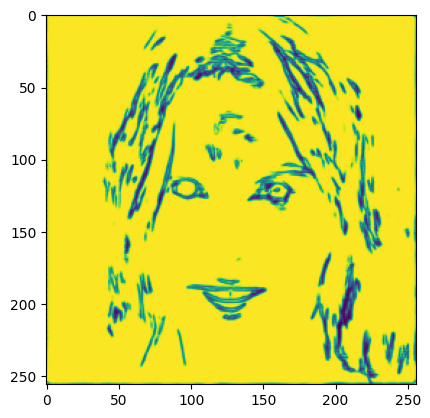

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Resize((256, 256)), 
    transforms.Normalize(0.5,0.5),
])

# Load only 10 percent of the training dataset
train_dataset = SketchPhotoDataset(img_dir='./archive/train/photos', sketch_dir='./archive/train/sketches', transform=transform)
test_dataset = SketchPhotoDataset(img_dir='./archive/test/photos', sketch_dir='./archive/test/sketches', transform=transform)
train_size = int(0.3 * len(train_dataset))
test_size = int(0.5 * len(test_dataset))
# Load the testing dataset
train_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, len(train_dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset, _ = torch.utils.data.random_split(test_dataset, [test_size, len(test_dataset) - test_size])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(test_dataset))
# Example of iterating through the training data
for images, sketches in train_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(images[0].shape)
    plt.show()

    plt.imshow(sketches[0].permute(1, 2, 0))
    print(sketches[0].shape)    
    plt.show()
    break

In [6]:
def rescale_image(image):
    return (image + 1) / 2

In [7]:
def test_model(generator, test_loader):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for i, (photos, sketches) in enumerate(test_loader):
            sketches, photos = sketches.cuda().float(), photos.cuda().float()
            generated_photos = generator(sketches)

            # Rescale images from [-1, 1] to [0, 1]
            sketches = rescale_image(sketches)
            photos = rescale_image(photos)
            generated_photos = rescale_image(generated_photos)

            # Plot the input sketch, ground truth photo, and generated photo
            fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
            for j in range(5):
                axes[0, j].imshow(sketches[j].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
                axes[0, j].set_title('Sketch')
                axes[0, j].axis('off')

                axes[1, j].imshow(photos[j].cpu().permute(1, 2, 0))
                axes[1, j].set_title('Ground Truth')
                axes[1, j].axis('off')

                axes[2, j].imshow(generated_photos[j].cpu().permute(1, 2, 0))
                axes[2, j].set_title('Generated')
                axes[2, j].axis('off')

            plt.show()
            break  # Only process the first batch for visualization

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
        self.apply(weights_init)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=3),
            nn.Sigmoid(),
        )
        
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

In [11]:
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

In [12]:
# Initialize models
generator = UNetGenerator().cuda()
discriminator = PatchGANDiscriminator().cuda()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

print(discriminator)
print(generator)

PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (12): Sigmoid()
  )
)
UNetGenerator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, ke

In [13]:
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, checkpoint_dir='cgan_checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))

In [ ]:
def load_checkpoint(generator, discriminator, optimizer_G, optimizer_D, checkpoint_dir='cgan_checkpoints'):
    if not os.path.exists(checkpoint_dir):
        raise Exception(f'No checkpoint directory found at {checkpoint_dir}')
    latest_checkpoint = max(os.listdir(checkpoint_dir))
    checkpoint = torch.load(os.path.join(checkpoint_dir, latest_checkpoint))
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    return checkpoint['epoch']

load_checkpoint(generator, discriminator, optimizer_G, optimizer_D)

In [14]:
# Training loop
g_losses = []
d_losses = []


num_epochs = 100
for epoch in range(num_epochs):
    for i, (photos, sketches) in enumerate(train_loader):
        sketches, photos = sketches.cuda().float(), photos.cuda().float()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(sketches.size(0), 1, 70, 70).cuda()
        fake_labels = torch.zeros(sketches.size(0), 1, 70, 70).cuda()

        outputs = discriminator(torch.cat((sketches, photos), 1))
        d_loss_real = criterion_GAN(outputs, real_labels)

        fake_images = generator(sketches)
        outputs = discriminator(torch.cat((sketches, fake_images.detach()), 1))
        d_loss_fake = criterion_GAN(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(torch.cat((sketches, fake_images), 1))
        g_loss_GAN = criterion_GAN(outputs, real_labels)
        g_loss_L1 = criterion_L1(fake_images, photos) * 80
        g_loss = g_loss_GAN + g_loss_L1
        g_loss.backward()
        optimizer_G.step()

        # Save losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Save generated images for visualization
    if epoch % 10 == 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)

        plt.imshow(sketches[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.title('Sketch')
        plt.subplot(1, 2, 2)
        plt.imshow(rescale_image(fake_images[0]).detach().cpu().permute(1, 2, 0))
        plt.title('Generated Photo')
        plt.show()
        save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D)

/home/wahab/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [0/100], Step [0/33], D Loss: 1.6990325450897217, G Loss: 41.68390655517578


KeyboardInterrupt: 

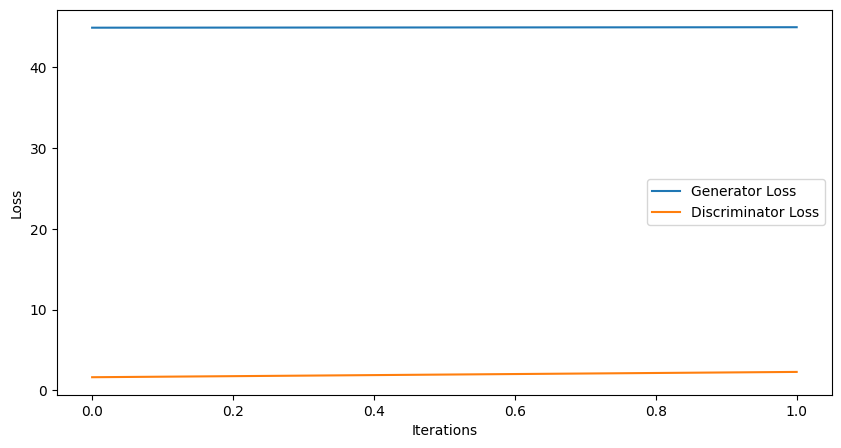

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

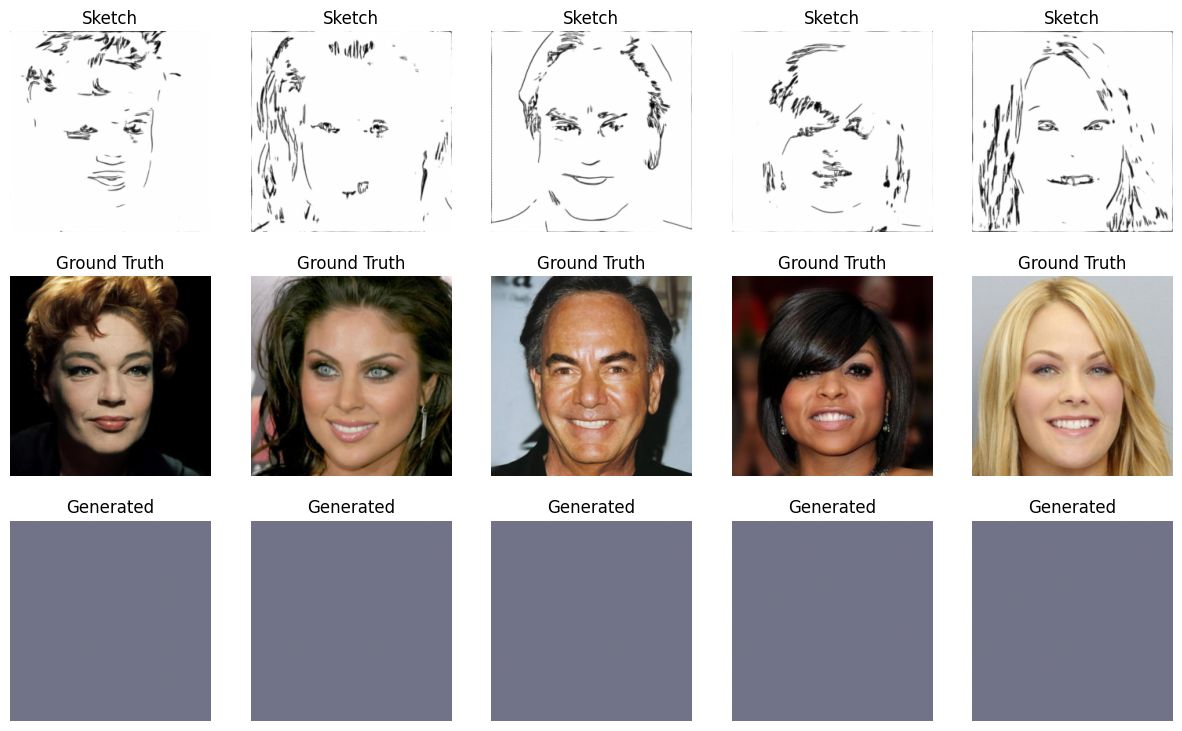

In [54]:
test_model(generator, test_loader)

In [55]:
# Save the trained models
torch.save(generator.state_dict(), 'model/generator.pth')
torch.save(discriminator.state_dict(), 'model/discriminator.pth')